In [17]:
# 시험환경 세팅 (코드 변경 X)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def exam_data_load(df, target, id_name="", null_name=""):
    if id_name == "":
        df = df.reset_index().rename(columns={"index": "id"})
        id_name = 'id'
    else:
        id_name = id_name
    
    if null_name != "":
        df[df == null_name] = np.nan
    
    X_train, X_test = train_test_split(df, test_size=0.2, random_state=2021)
    
    y_train = X_train[[id_name, target]]
    X_train = X_train.drop(columns=[target])

    
    y_test = X_test[[id_name, target]]
    X_test = X_test.drop(columns=[target])
    return X_train, X_test, y_train, y_test 
    
df = pd.read_csv("../input/insurance/insurance.csv")
X_train, X_test, y_train, y_test = exam_data_load(df, target='charges')

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1070, 7), (268, 7), (1070, 2), (268, 2))

# EDA

In [18]:
X_train.head()

,id,age,sex,bmi,children,smoker,region
209,209,40,male,41.230,1,no,northeast
540,540,34,female,38.000,3,no,southwest
747,747,19,male,21.755,0,no,northwest
39,39,60,male,39.900,0,yes,southwest
640,640,33,male,42.400,5,no,southwest


In [19]:
y_train.head()

,id,charges
209,209,6610.10970
540,540,6196.44800
747,747,1627.28245
39,39,48173.36100
640,640,6666.24300


<AxesSubplot:>

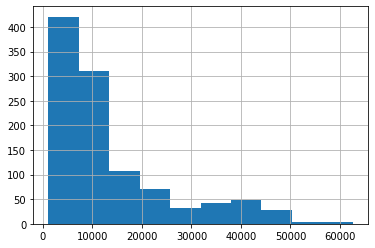

In [20]:
y_train['charges'].hist()

In [21]:
X_train.isnull().sum()

id          0
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
dtype: int64

In [22]:
X_test.isnull().sum()

id          0
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
dtype: int64

In [23]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 209 to 1140
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        1070 non-null   int64  
 1   age       1070 non-null   int64  
 2   sex       1070 non-null   object 
 3   bmi       1070 non-null   float64
 4   children  1070 non-null   int64  
 5   smoker    1070 non-null   object 
 6   region    1070 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 66.9+ KB


In [24]:
X_train.select_dtypes('object').columns

Index(['sex', 'smoker', 'region'], dtype='object')

In [25]:
# Train ['sex', 'smoker', 'region']
cols = X_train.select_dtypes("object").columns

for col in cols:
    print("\n=====", col, "=====")
    print("[train]")
    print(X_train[col].value_counts())
    print("[test]")
    print(X_test[col].value_counts())


===== sex =====
[train]
male      551
female    519
Name: sex, dtype: int64
[test]
female    143
male      125
Name: sex, dtype: int64

===== smoker =====
[train]
no     845
yes    225
Name: smoker, dtype: int64
[test]
no     219
yes     49
Name: smoker, dtype: int64

===== region =====
[train]
southeast    304
northeast    266
southwest    261
northwest    239
Name: region, dtype: int64
[test]
northwest    86
southwest    64
southeast    60
northeast    58
Name: region, dtype: int64


# Preprocessing

### Categorical Variable

In [26]:
X_train = pd.get_dummies(X_train, columns = cols)
X_test = pd.get_dummies(X_test, columns = cols)

In [27]:
X_train.head()

,id,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
209,209,40,41.230,1,0,1,1,0,1,0,0,0
540,540,34,38.000,3,1,0,1,0,0,0,0,1
747,747,19,21.755,0,0,1,1,0,0,1,0,0
39,39,60,39.900,0,0,1,0,1,0,0,0,1
640,640,33,42.400,5,0,1,1,0,0,0,0,1


### Log Transform

<AxesSubplot:>

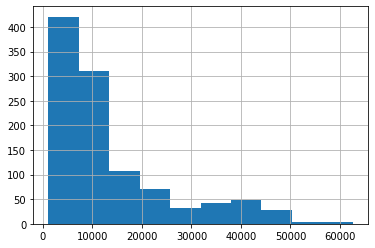

In [28]:
y_train['charges'].hist()

In [29]:
y_train['charges'] = np.log1p(y_train['charges'])

<AxesSubplot:>

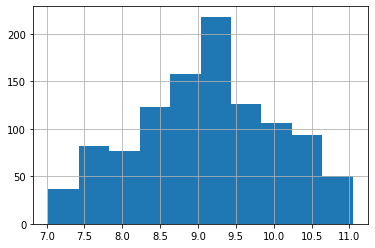

In [30]:
y_train['charges'].hist()

## Standard Scaler

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train['bmi'] = scaler.fit_transform(X_train[['bmi']])
X_test['bmi'] = scaler.transform(X_test[['bmi']])

In [33]:
X_train.head(3)

,id,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
209,209,40,1.707232,1,0,1,1,0,1,0,0,0
540,540,34,1.180775,3,1,0,1,0,0,0,0,1
747,747,19,-1.466991,0,0,1,1,0,0,1,0,0


## label encoding

In [34]:
# 나이를 10대, 20대, 30대로 구분하기 위해 10을 나눈 몫 값만 구함
X_train['age'] = X_train['age'].apply(lambda x: x//10)
X_test['age'] = X_test['age'].apply(lambda x: x//10)

X_train.head()

,id,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
209,209,4,1.707232,1,0,1,1,0,1,0,0,0
540,540,3,1.180775,3,1,0,1,0,0,0,0,1
747,747,1,-1.466991,0,0,1,1,0,0,1,0,0
39,39,6,1.490456,0,0,1,0,1,0,0,0,1
640,640,3,1.897930,5,0,1,1,0,0,0,0,1


## Train-Validation Split

In [35]:
target = y_train['charges']
X_train = X_train.drop('id', 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [36]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(X_train, target, test_size = 0.15, random_state = 2022)
X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

((909, 11), (161, 11), (909,), (161,))

In [46]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

model.fit(X_tr, y_tr)

pred = model.predict(X_val)

In [47]:
from sklearn.metrics import mean_squared_error

In [48]:
import numpy as np

In [49]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))

In [50]:
print('rmse :', rmse(y_val, pred))

rmse : 0.38428069947420357


In [52]:
from xgboost import XGBRegressor

In [55]:
model = XGBRegressor()

model.fit(X_tr, y_tr)
pred = model.predict(X_val)

print('rmse : ', rmse(y_val, pred))

rmse :  0.39580148944349686


In [57]:
model = RandomForestRegressor()

model.fit(X_train, y_train['charges'])
pred = model.predict(X_test.drop('id',1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [58]:
pred = np.exp(pred)
output = pd.DataFrame({'id': y_test['id'], 'charges':pred})
output.head()

,id,charges
1088,1088,9584.213006
1157,1157,4329.780445
1267,1267,34179.026746
506,506,2976.837209
659,659,13025.502011
